# Churn Prediction For ClientCo

## Group 3

**Team Members:**
* Benjamin CERF
* Pau BARDO VENTURA
* Ling YANG
* Jashanni UTHAYAKUMAR
* Cathal BRADY
* Rania BENNANI


### Background:
In this notebook we use the sales data and the customer type data which was supplied from ClientCo to build a churn prediction model. Our final model is an XGBoost Classifier which leverages extensive feature engineering to build what we feel is an optimal model with an F1-score of 81% on detecting churners/non-churners. In our model a churner is defined as a client who does not return to the store for more than 30 days. We reasoned this from the fact that 94% of ClientCos customers return inside 30 days, which makes sense considering ClientCo's clients are likely builders who need materials on a continuous basis. Our mission is to identify these clients who we predict may churn and intervene with targetted contact from a sales rep/targetted promotion offer 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import gc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import confusion_matrix


In [3]:
df = pd.read_csv('../transactions_dataset.csv', sep=';')
df = df[df['sales_net'] > 0]  # Exclude the often duplicate 0 sales transactions 
                                # And exclude refunds 

In [4]:
df.columns

Index(['date_order', 'date_invoice', 'product_id', 'client_id', 'sales_net',
       'quantity', 'order_channel', 'branch_id'],
      dtype='object')

## EDA (Exploratory Data Analysis)


We can see that most clients purchase in store this is aligned with the interview minutes we received. 

Frequency Counts:
 order_channel
at the store                       28915898
by phone                           23984480
online                              5530369
other                                 57016
during the visit of a sales rep       26804
Name: count, dtype: int64


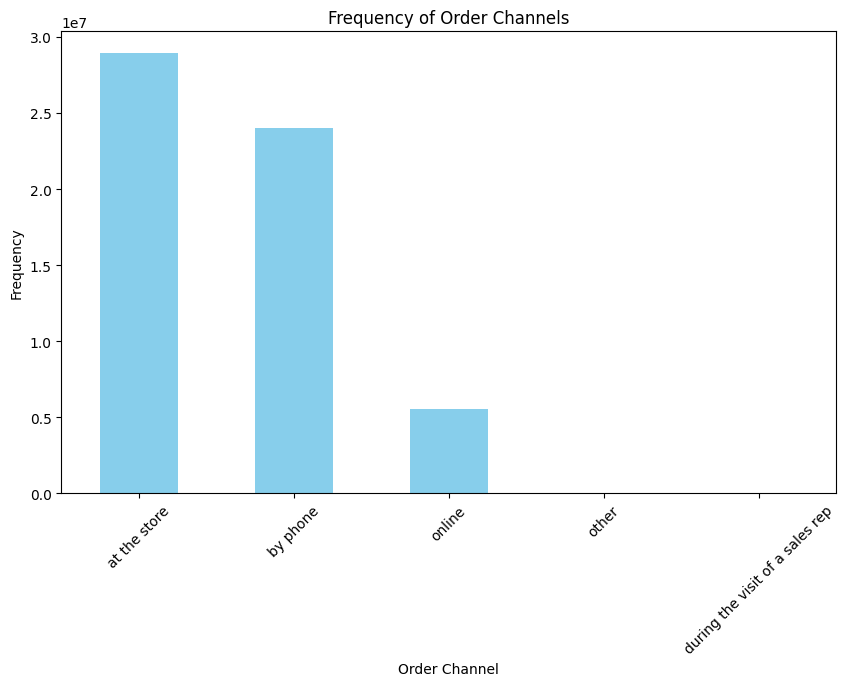

In [88]:
order_channel_counts = df['order_channel'].value_counts()

# Print the frequency counts
print("Frequency Counts:\n", order_channel_counts)

# Plot the histogram
plt.figure(figsize=(10, 6))
order_channel_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Order Channels')
plt.xlabel('Order Channel')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


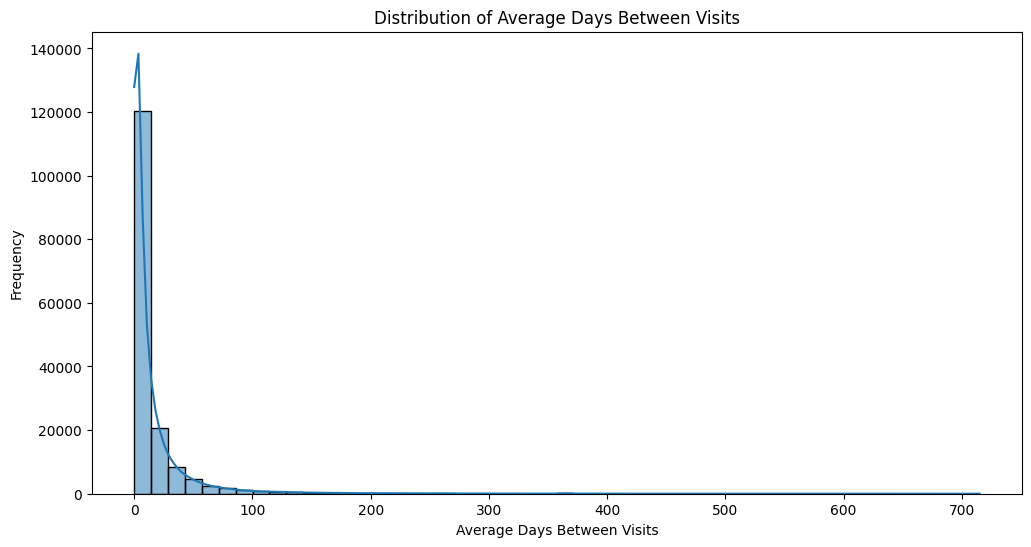

In [7]:
df_sorted = df.sort_values(by=['client_id', 'date_order'])

df_sorted['date_order'] = pd.to_datetime(df_sorted['date_order'])
df_sorted['days_between_visits'] = df_sorted.groupby('client_id')['date_order'].diff().dt.days

avg_days_between_visits = df_sorted.groupby('client_id')['days_between_visits'].mean().reset_index()

avg_days_between_visits = avg_days_between_visits.dropna()

plt.figure(figsize=(12, 6))
sns.histplot(avg_days_between_visits['days_between_visits'], bins=50, kde=True)
plt.title('Distribution of Average Days Between Visits')
plt.xlabel('Average Days Between Visits')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Technical operation to free some unneccessary stuff from memory 
gc.collect()

708

Find how recently clients have visited and set those who have not for >30 days are considered inactive

In [9]:
# Group by client and check the last date_order, then calculate the recency
df['date_order'] = pd.to_datetime(df['date_order'])
recency = df.groupby('client_id')['date_order'].max().reset_index()
recency['recency'] = recency['date_order'].max() - recency['date_order']
recency['recency'] = recency['recency'].apply(lambda x: x.days)

# Remove the date_order column
recency.drop('date_order', axis=1, inplace=True)

# Identify with a dummy those who have not bought in the last 30 days
recency['inactive'] = recency['recency'] > 30

In [19]:
# Restrict the data to people who bought something in the last 60 days 
recency = recency[recency['recency'] < 60]

# Calculate the proportion of churners
print(f'Proportion of inactive clients in last 60 days: {recency["inactive"].mean():.2f}')

Proportion of inactive clients in last 60 days: 0.23


Add features such as number of different date_order, number of different products bought, nb of days since first order,
average basket, frequency of orders

In [20]:
mask = df['date_order'] <= df['date_order'].max() - pd.Timedelta(days=30) # Remove the last month of data
features = df[mask].groupby(['client_id']).agg({'date_order': ['nunique', 'min'], 'product_id': 'nunique', 'sales_net': 'mean'})
features.columns = ['nb_orders', 'first_order', 'nb_products', 'average_basket']

# Create new features
features['days_since_first_order'] = (df['date_order'].max() - features['first_order']).dt.days
features['frequency'] = features['nb_orders'] / features['days_since_first_order']
features = features.drop('first_order', axis=1)

In [21]:
# Compute % of sales per channel for each client
mask = df['date_order'] <= df['date_order'].max() - pd.Timedelta(days=30) # Remove the last month of data
channel_sales = df[mask].groupby(['client_id', 'order_channel'])['sales_net'].sum().unstack(fill_value=0)
channel_sales = channel_sales.div(channel_sales.sum(axis=1), axis=0) * 100

In [22]:
# Merge features and channel_sales
features = features.merge(channel_sales, on='client_id', how='left')
features.head()

,nb_orders,nb_products,average_basket,days_since_first_order,frequency,at the store,by phone,during the visit of a sales rep,online,other
client_id,,,,,,,,,,
6,13,35,163.395361,695,0.018705,22.416561,77.583439,0.0,0.000000,0.0
7,2,10,79.385139,433,0.004619,100.000000,0.000000,0.0,0.000000,0.0
14,487,4757,260.104439,727,0.669876,1.949063,83.340556,0.0,14.710381,0.0
18,281,759,117.717070,726,0.387052,38.236234,56.830327,0.0,4.933439,0.0
25,1,4,93.646524,347,0.002882,100.000000,0.000000,0.0,0.000000,0.0


In [23]:
# Create a DF with monthly features
monthly_stats = df.loc[mask].groupby(['client_id', pd.Grouper(key='date_order', freq='M')]).agg({
    'date_order': 'nunique', 
    'sales_net': 'sum'
}).unstack(fill_value=0)

# Rename columns
monthly_stats.columns = [f"{col[0]}_{col[1].strftime('%Y-%m')}" for col in monthly_stats.columns]

C:\Users\35387\AppData\Local\Temp\ipykernel_29604\3336943408.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_stats = df.loc[mask].groupby(['client_id', pd.Grouper(key='date_order', freq='M')]).agg({


In [25]:
# Compute the monthly evolutions in %
monthly_pct_change = monthly_stats.pct_change(axis=1).multiply(100).add_suffix('_pct_change')

# Replace inf with NaN
monthly_pct_change.replace([np.inf, -np.inf], np.nan, inplace=True)

In [26]:
# Calculer la variance de 'date_order' et 'sales_net' sur toute la période
# Calculer la variance pour chaque type de colonne
date_order_variance = monthly_stats.filter(like='date_order').var(axis=1).rename('date_order_variance')
sales_net_variance = monthly_stats.filter(like='sales_net').var(axis=1).rename('sales_net_variance')

# Moyennes sur les 6 et 3 derniers mois
rolling_6m = monthly_stats.rolling(window=6, axis=1).mean().add_suffix('_avg_6m')
rolling_3m = monthly_stats.rolling(window=3, axis=1).mean().add_suffix('_avg_3m')
rolling_6m = rolling_6m[['date_order_2019-08_avg_6m', 'sales_net_2019-08_avg_6m']]
rolling_3m = rolling_3m[['date_order_2019-08_avg_3m', 'sales_net_2019-08_avg_3m']]

C:\Users\35387\AppData\Local\Temp\ipykernel_29604\3604132426.py:7: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_6m = monthly_stats.rolling(window=6, axis=1).mean().add_suffix('_avg_6m')
C:\Users\35387\AppData\Local\Temp\ipykernel_29604\3604132426.py:8: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  rolling_3m = monthly_stats.rolling(window=3, axis=1).mean().add_suffix('_avg_3m')


In [27]:
# Merge with features
features_v2 = features.join(monthly_stats, on='client_id')
features_v2 = features_v2.join(monthly_pct_change, on='client_id')
features_v2 = features_v2.join(date_order_variance, on='client_id')
features_v2 = features_v2.join(sales_net_variance, on='client_id')
features_v2 = features_v2.join(rolling_6m, on='client_id')
features_v2 = features_v2.join(rolling_3m, on='client_id')

In [28]:
# Merge the two dataframes
data = recency.merge(features_v2, on='client_id', how='left')

In [29]:
# Merge with the client relationship dataset
client_relationship = pd.read_csv('../sales_client_relationship_dataset.csv')

data = data.merge(client_relationship, on='client_id', how='left')

Full suite of features we have made are shown below

In [30]:
data.columns

Index(['client_id', 'recency', 'inactive', 'nb_orders', 'nb_products',
       'average_basket', 'days_since_first_order', 'frequency', 'at the store',
       'by phone',
       ...
       'sales_net_2019-06_pct_change', 'sales_net_2019-07_pct_change',
       'sales_net_2019-08_pct_change', 'date_order_variance',
       'sales_net_variance', 'date_order_2019-08_avg_6m',
       'sales_net_2019-08_avg_6m', 'date_order_2019-08_avg_3m',
       'sales_net_2019-08_avg_3m', 'quali_relation'],
      dtype='object', length=116)

In [32]:
# Replace the days_since_first_order by a categorical variable
# If days_since_first_order > 600, then old_client = 1
data['old_client'] = data['days_since_first_order'] > 600

# Remove the days_since_first_order column
data = data.drop('days_since_first_order', axis=1)

In [33]:
# Change the names of some columns
data = data.rename(columns={'at the store': 'at_store', 'by phone': 'phone',
                            'during the visit of a sales rep': 'sales_rep'})

In [34]:
# Transform quali_relation into dummies
data = pd.get_dummies(data, columns=['quali_relation'])

In [35]:
data.drop(columns=['date_order_2017-09_pct_change'], inplace=True)

### Train a RandomForest Classifier and an XGBoost Classifier

In [36]:
y =  data['inactive']
X = data.drop(['client_id', 'inactive', 'recency'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[13036  1110]
 [ 2332  1925]]
              precision    recall  f1-score   support

       False       0.85      0.92      0.88     14146
        True       0.63      0.45      0.53      4257

    accuracy                           0.81     18403
   macro avg       0.74      0.69      0.71     18403
weighted avg       0.80      0.81      0.80     18403

AUC-ROC: 0.8615069295966846


In [37]:
# XGboost model
model = XGBClassifier(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[12931  1215]
 [ 2136  2121]]
              precision    recall  f1-score   support

       False       0.86      0.91      0.89     14146
        True       0.64      0.50      0.56      4257

    accuracy                           0.82     18403
   macro avg       0.75      0.71      0.72     18403
weighted avg       0.81      0.82      0.81     18403

AUC-ROC: 0.8678904409105074


XGBoost performs very well but lets see if we can achieve the same performance with less features to create a more robust model. For this we will use recursive feature elimination to reduce the number of features 

In [38]:
model = XGBClassifier(n_estimators=20, random_state=42)

# Initialize RFECV with the model and the cross-validation strategy
# StratifiedKFold is used to preserve the distribution of classes in each fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='roc_auc')

# Fit RFECV
rfecv.fit(X_train, y_train)

# Print the optimal number of features
print("Optimal number of features:", rfecv.n_features_)

# Get the selected features
selected_features = X_train.columns[rfecv.support_]

# Print the selected features
print("Selected Features:", selected_features)

Optimal number of features: 18
Selected Features: Index(['nb_orders', 'nb_products', 'frequency', 'other', 'date_order_2018-09',
       'date_order_2019-02', 'date_order_2019-07', 'date_order_2019-08',
       'sales_net_2018-09', 'sales_net_2019-04', 'sales_net_2019-08',
       'date_order_2019-07_pct_change', 'sales_net_2017-09_pct_change',
       'sales_net_2018-10_pct_change', 'sales_net_2019-07_pct_change',
       'date_order_variance', 'date_order_2019-08_avg_6m',
       'date_order_2019-08_avg_3m'],
      dtype='object')


In [39]:
selected_features = selected_features.tolist()
if 'other' in selected_features:
    selected_features.remove('other')

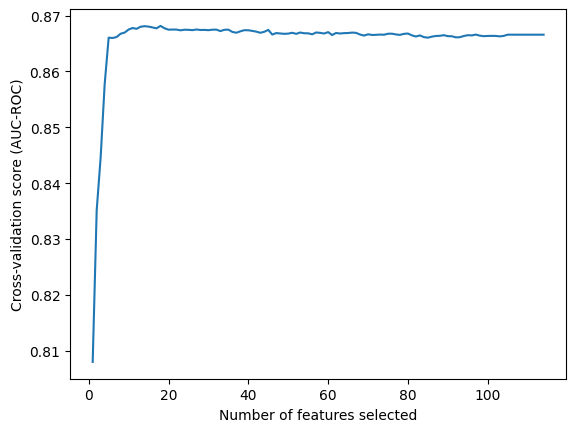

In [40]:
# Plot number of features vs. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation score (AUC-ROC)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

We will now retrain the model with the reduced number of features and use this model for inference

In [41]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

[[12910  1236]
 [ 2144  2113]]
              precision    recall  f1-score   support

       False       0.86      0.91      0.88     14146
        True       0.63      0.50      0.56      4257

    accuracy                           0.82     18403
   macro avg       0.74      0.70      0.72     18403
weighted avg       0.81      0.82      0.81     18403

AUC-ROC: 0.8674563707098173


Get feature importances

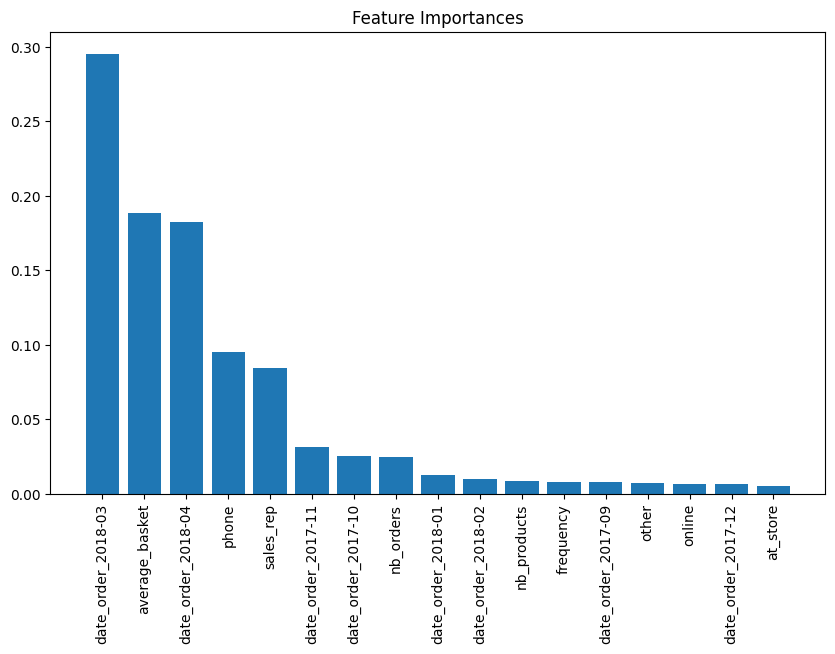

In [100]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.bar(range(X_train_selected.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train_selected.shape[1]), X.columns[indices], rotation=90)
plt.show()

## Bonus Question: Targetting a marketting budget of 100k on clients we predict to churn 

In [42]:
churn_predicted_clients = X_test[y_pred == 1].copy()  # Those we predict to churn
y_test.name = 'actually_churned'
churn_predicted_clients = pd.merge(churn_predicted_clients, y_test, how='left', left_index=True, right_index=True)

# Calculate total sales for these clients
churn_predicted_clients['total_sales'] = churn_predicted_clients['nb_orders'] * churn_predicted_clients['average_basket']

# Add a column for the preferred channel
churn_predicted_clients['preferred_channel'] = churn_predicted_clients[['at_store', 'phone', 'sales_rep', 'online', 'other']].idxmax(axis=1)

# Sort clients by total sales in decreasing order
churn_predicted_clients.sort_values(by='total_sales', ascending=False, inplace=True)

# Display the top high-value clients predicted to churn
print("Top High-Value Clients Predicted to Churn (Sorted by Total Sales):")
print(churn_predicted_clients[['nb_orders', 'nb_products', 'total_sales', 'frequency']].head(10))

# Budget allocation
phone_call_cost = 80
site_visit_cost = 320
budget = 100000

Top High-Value Clients Predicted to Churn (Sorted by Total Sales):
       nb_orders  nb_products    total_sales  frequency
9628         3.0          3.0  160794.150000   0.004386
27139        4.0          5.0  157375.989360   0.007273
89610      361.0       2462.0  107366.453355   0.497931
38815      137.0        651.0   95954.892545   0.188705
60725       68.0        214.0   63214.690207   0.094840
26002        2.0          7.0   54314.291235   0.026316
25004       33.0         40.0   50108.079053   0.045580
29309        5.0         15.0   49640.854000   0.011574
55204      120.0        526.0   49346.987418   0.196078
24817      196.0        645.0   43519.331649   0.272222


Budget allocation based on the price of a call/site visit on clients we predict to churn

**Given the high cost of site visits we only target them at clients who have previously bought during the visit of a sales rep**

We also allow the 100k budget not to be exhausted

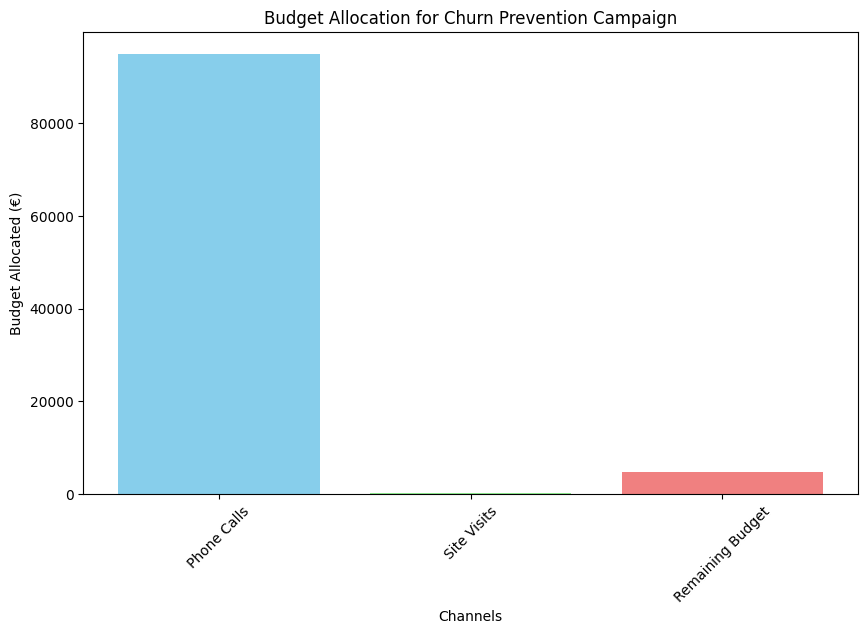

In [47]:
# Budget allocation
phone_call_cost = 80
site_visit_cost = 320
budget = 100000
prop_phone_call = 0.95  # can play with these
prop_site_visits = 1 - prop_phone_call

# Calculate the number of clients that can be targeted with the budget
num_phone_calls = (budget * prop_phone_call) // phone_call_cost
num_site_visits = (budget * prop_site_visits) // site_visit_cost

# Select top clients for phone calls and site visits based on preferred channel
top_clients_phone_calls = churn_predicted_clients[churn_predicted_clients['preferred_channel'] == 'phone'].head(int(num_phone_calls))
top_clients_site_visits = churn_predicted_clients[churn_predicted_clients['preferred_channel'] == 'sales_rep'].head(int(num_site_visits))

# Calculate the actual budget spent
budget_spent_phone = len(top_clients_phone_calls) * phone_call_cost
budget_spent_site = len(top_clients_site_visits) * site_visit_cost

# Visualize the budget allocation
channel_budget = {
    'Phone Calls': budget_spent_phone,
    'Site Visits': budget_spent_site,
    'Remaining Budget': budget - (budget_spent_phone + budget_spent_site)
}

# Plot the budget allocation
plt.figure(figsize=(10, 6))
plt.bar(channel_budget.keys(), channel_budget.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Budget Allocation for Churn Prevention Campaign')
plt.xlabel('Channels')
plt.ylabel('Budget Allocated (€)')
plt.xticks(rotation=45)
plt.show()

Find the true cost per € spent on marketting. This is the cost assigned to people we called who would have returned anyway. We cant find the sales uplift which would result from intervention without A/B testing - we would reccommend this as a next step as it would give a fuller picture

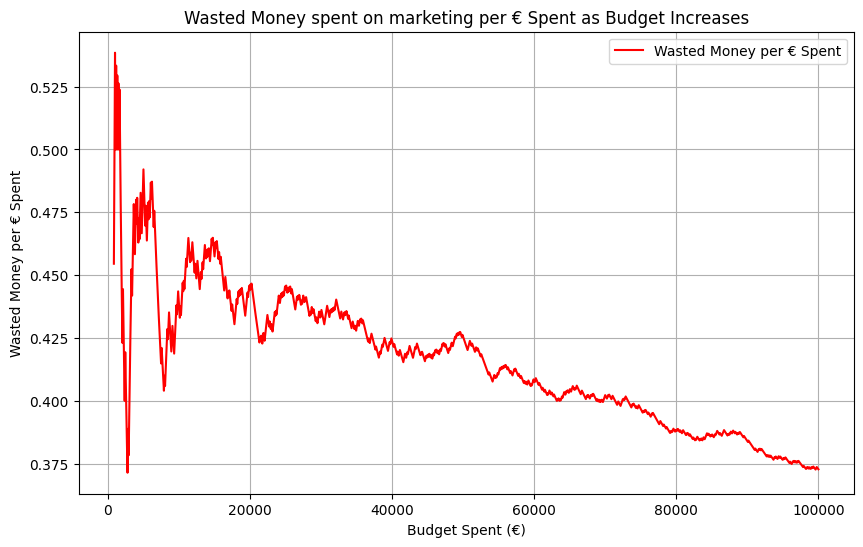

In [48]:
# Track wasted money and budget spent
wasted_money = []
budget_spent = []
current_budget = 0

# Simulate budget allocation
for index, row in churn_predicted_clients.iterrows():
    if current_budget >= budget:
        break

    # Determine the cost of intervention based on the preferred channel
    if row['preferred_channel'] == 'phone':
        intervention_cost = phone_call_cost
    elif row['preferred_channel'] == 'sales_rep':
        intervention_cost = site_visit_cost
    else:
        continue  # Skip if the channel is not phone or sales_rep

    # Update the current budget
    current_budget += intervention_cost

    # Track budget spent and wasted money
    budget_spent.append(current_budget)
    if row['actually_churned'] == 0:
        wasted_money.append(intervention_cost)
    else:
        wasted_money.append(0)

# Calculate cumulative wasted money
cumulative_wasted_money = np.cumsum(wasted_money)

# Calculate wasted money per € spent
wasted_per_euro = cumulative_wasted_money / np.array(budget_spent)

# Exclude the first few data points to smooth out the initial spike
exclude_initial = 10  # Number of initial data points to exclude
budget_spent_smooth = budget_spent[exclude_initial:]
wasted_per_euro_smooth = wasted_per_euro[exclude_initial:]

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(budget_spent_smooth, wasted_per_euro_smooth, label='Wasted Money per € Spent', color='red')
plt.title('Wasted Money spent on marketing per € Spent as Budget Increases')
plt.xlabel('Budget Spent (€)')
plt.ylabel('Wasted Money per € Spent')
plt.legend()
plt.grid(True)
plt.show()


In [49]:
print('Total waste on 100k spend: €', sum(wasted_money))

Total waste on 100k spend: € 37280
